In [2]:
%matplotlib inline
import velocyto as vcy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from copy import deepcopy
import pickle
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import pysam
import time

/home/smudge/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Part -1: create .loom file from .bam

**Goal:** merge 6 .bam files (3 BRCA, 3 normal) containing scRNA-seq reads. Run velocyto CLI on these files to obtain one merged .loom file for velocity analysis.

In [ ]:
#start time:
start_time = time.time()

#parse each bam file to get a list of barcodes:
ind_name = "ind4"
ind_dir = "/data1/rna_velocity_data/{}/".format(ind_name)
suffix = "4"

sam_infile = pysam.AlignmentFile("{}possorted_genome_bam.bam".format(ind_dir), "rb")
sam_outfile = pysam.AlignmentFile("{}{}_fixed_barcodes.bam".format(ind_dir, ind_name), "wb", template=sam_infile)

for read in sam_infile:
    try:
        barcode = read.get_tag('CB').split("-")[0] + "-{}".format(suffix)
        read.set_tag('CB', barcode)
        sam_outfile.write(read)
    except: pass

#close out of sam files:
sam_infile.close()
sam_outfile.close()

end_time = time.time()


In [42]:
print((end_time - start_time) / 60, "minutes elapsed")

150.9180031855901 minutes elapsed


In [40]:
#write relevant barcodes from metadata file with corrected suffix to output file (done for all 6 samples!!)
with open("{}{}_barcodes.tsv".format(ind_dir,ind_name), 'w') as f:
    for barcode in [b.split("_")[-1] + "-{}".format(suffix) + "\n" for b in metadata.index if ind_name in b]: f.write(barcode)


Below is the **samtools merge command** used to combine the six .bam file samples.

In [ ]:
! samtools merge -nf --threads 16 -h ind1/possorted_genome_bam.bam merged/merged.bam ind1/possorted_genome_bam.bam ind2/ind2_fixed_barcodes.bam ind3/ind3_fixed_barcodes.bam ind4/ind4_fixed_barcodes.bam ind9/ind9_fixed_barcodes.bam ind10/ind10_fixed_barcodes.bam 

Below is the **velocyto CLI command** used to generate .loom file containing spliced and unspliced counts matrices.

In [ ]:
#ind9
! velocyto run -b ind9/ind9_barcodes.tsv -o ind9/test_velo/ -m ~/Documents/kessenbrock_lab/resources/grch38_rmsk.gtf -@ 8 ind9/ind9_fixed_barcodes.bam ~/Documents/kessenbrock_lab/resources/Homo_sapiens.GRCh38.94.chr.gtf 

# BRCA1 breast epithelium RNA velocity analysis

Write some stuff about the RNA velocity analysis

# Part 0: Load data

We are either going to load a completely unprocessed .loom file (option 1), which is the the result of running the [Velocyto command line interface (CLI)], or we are going to load a .hdf5 file containing RNA velocity data that we have processed previously (option2).

### Option 1: load unprocessed .loom file

In [16]:
#load loom files for all inds:
#ind = vcy.VelocytoLoom("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/rna_velocity_data/ind10/possorted_genome_bam_DZN3A.loom")

ind = vcy.VelocytoLoom("/data1/rna_velocity_data/ind9/test_velo/ind9_fixed_barcodes_FKQW4.loom")
#trim barcode stem assigned by velocyto CLI (not always necessary)
#ind.ca['CellID'] = np.array([b.split(":")[1] for b in ind.ca["CellID"]])

In [17]:
ind9_barcodes = [b.split(":")[1][:-1]  for b in ind.ca['CellID']]

In [18]:
ind.ca['CellID'] = np.array(ind9_barcodes)

In [ ]:
#plt.style.use('ggplot')
ind.plot_fractions("/home/smudge/Desktop/ind4_fractions.pdf")
plt.legend(["ind4"])

/home/smudge/anaconda3/lib/python3.6/site-packages/velocyto/analysis.py:117: RuntimeWarning: invalid value encountered in true_divide
  _mean = [np.mean(j / total) for j in tot_mol_cell_submatrixes]
/home/smudge/anaconda3/lib/python3.6/site-packages/velocyto/analysis.py:118: RuntimeWarning: invalid value encountered in true_divide
  _std = [np.std(j / total) for j in tot_mol_cell_submatrixes]


KeyboardInterrupt: 

### Option 2: load fully processed .hdf5 file


In [20]:
ind = pickle.load(open("/data1/rna_velocity_data/ind4/ind4.hdf5", 'rb'))

### Set plotting info
Set the individual that we are currently analyzing, and specify the directory where you would like plots to be saved.

In [10]:
ind_name = "ind9"
print_dir = "~/Desktop"
#barcode_stem = "ind10.epithelial.NORMAL_"

In [226]:
#figure out barcode stem for this individual
[b for b in metadata.index if ind_name in b][:5]

['ind3.epithelial.BRCA_AAACCTGAGAACAACT',
 'ind3.epithelial.BRCA_AAACCTGAGTTAGGTA',
 'ind3.epithelial.BRCA_AAACCTGCAACTGCTA',
 'ind3.epithelial.BRCA_AAACCTGCACATCCGG',
 'ind3.epithelial.BRCA_AAACCTGCATATGAGA']

### Load metadata matrix

This data has previously been analyzed using Seurat in R, so we have already generated a matrix of valuable metadata that we will refer to throughout this analysis.

In [6]:
metadata = pd.read_table("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/Norm.BRCA.Combined.Seurat.Meta.Data.Object.txt")
metadata.set_index("barcode", inplace=True)
metadata.head()

,nGene,nUMI,orig.ident,individual,percent.mito,var.ratio.pca,res.0.8,Status,individual.analysis.idents,Coarse.Ident,...,Cell.Name,Visvader.Luminal.Prog1,Visvader.Mature.Luminal1,Visvader.MaSC1,tSNE_1,tSNE_2,res.0.4,Compartment,BRCA1_Reg_Up1,BRCA1_Reg_Down1
barcode,,,,,,,,,,,,,,,,,,,,,
ind1.epithelial.NORMAL_AAACATACGTACAC,2318,8762,ind1.epithelial.NORMAL,ind1,0.023288,0.787393,5,NORMAL,Basal,NORMAL.Basal,...,ind1.epithelial.NORMAL_AAACATACGTACAC,0.018692,-0.057146,0.030844,-25.199395,-15.315579,1,EPITHELIAL,-0.083042,-0.027993
ind1.epithelial.NORMAL_AAACATTGCCTCCA,1402,4568,ind1.epithelial.NORMAL,ind1,0.021454,0.875605,5,NORMAL,Basal,NORMAL.Basal,...,ind1.epithelial.NORMAL_AAACATTGCCTCCA,0.065568,-0.020162,0.060231,-23.390215,-13.693550,1,EPITHELIAL,0.047170,-0.116039
ind1.epithelial.NORMAL_AAACATTGTGAAGA,2325,10451,ind1.epithelial.NORMAL,ind1,0.040287,0.979275,9,NORMAL,Luminal_1,NORMAL.Luminal_1,...,ind1.epithelial.NORMAL_AAACATTGTGAAGA,0.215997,-0.028305,-0.101489,-9.736511,-23.845450,2,EPITHELIAL,-0.054075,0.195512
ind1.epithelial.NORMAL_AAACATTGTTCTTG,921,2745,ind1.epithelial.NORMAL,ind1,0.168003,0.866979,9,NORMAL,Luminal_1,NORMAL.Luminal_1,...,ind1.epithelial.NORMAL_AAACATTGTTCTTG,0.331546,0.029075,-0.068867,-3.784230,-18.023563,2,EPITHELIAL,0.045715,-0.067662
ind1.epithelial.NORMAL_AAACCGTGCCTTAT,3043,12363,ind1.epithelial.NORMAL,ind1,0.020383,0.789875,9,NORMAL,Luminal_1,NORMAL.Luminal_1,...,ind1.epithelial.NORMAL_AAACCGTGCCTTAT,0.265002,-0.035563,0.004331,-1.406133,-14.928051,2,EPITHELIAL,-0.060410,-0.259270


# RNA velocity data processing pipeline

1. **Filter out cells with low unspliced detection**
2. **Filter out cells based on Seurat metadata**
    * The Seurat metadata that we are using only contains barcodes for cells that have already been filtered out in the scRNA data processing pipeline, therefore we only care about the cells found in this metadata table.
3. **Filter out cells based on spliced detection levels**
4. **Filter out genes based on [CV vs mean fit](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=score_cv_vs#velocyto.analysis.VelocytoLoom.score_cv_vs_mean) (support vector regression)**
    * I do not fully understand what this is doing, however here we can tweak the number of genes that we filter out to include less or more genes downstream. Based on the paper it looks like this is used to select the most variable genes.
5. **Normalize spliced and unspliced data matrices based on molecule counts**
6. **Run PCA**
7. **Run [KNN imputation](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=knn_imputation#velocyto.analysis.VelocytoLoom.knn_imputation) (smoothing of the data matrix)**
8. **[Fit gamma values](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=fit_gammas#velocyto.analysis.VelocytoLoom.fit_gammas) for each cell using spliced and unspliced data matrices**
<img src="images/rna_velo_model.png" width="150">
9. **Compute RNA velocity**
    1. [Predict unspliced](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=predict_u#velocyto.analysis.VelocytoLoom.predict_U), using the gamma model fit.
    2. [Calculate velocity](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=calculate_velocity#velocyto.analysis.VelocytoLoom.calculate_velocity) as U_measured - U_predicted.
    3. [Calculate shift](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=shift#velocyto.analysis.VelocytoLoom.calculate_shift), change in gene expression dS/dt for each cell.
    4. [Extrapolate](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=extrapolate_cell#velocyto.analysis.VelocytoLoom.extrapolate_cell_at_t) the gene expression profile of each cell after a specified dt. 
    
---
---

Before any filtering, let's look at how many genes and cells we have in our data matrix.

In [19]:
print("Number of cells in {} .loom file: {}".format(ind_name, ind.ca["CellID"].shape[0]))
print("Number of genes in {} .loom file: {}".format(ind_name, ind.ra["Gene"].shape[0]))
print(ind.S.shape)

Number of cells in ind9 .loom file: 15052
Number of genes in ind9 .loom file: 58676
(58676, 15052)


In [20]:
# remove cells with extremely low unspliced detection 
# (0.5th percentile of number of unspliced transcripts)
ind.filter_cells(bool_array=ind.initial_Ucell_size > np.percentile(ind.initial_Ucell_size, 0.5))
print(ind.S.shape)

(58676, 6180)


In [21]:
# assign a cell type cluster name to each barcode based on Seurat metadata
cell_id_dict = {barcode.split("_")[1]: metadata[metadata["individual"] == ind_name]["individual.analysis.idents"][barcode] for barcode in list(metadata[metadata["individual"] == ind_name].index)}
barcode_bool = np.array([True if barcode in cell_id_dict.keys() else False for barcode in ind.ca['CellID']])
clusternames = np.array([cell_id_dict[barcode] for barcode in ind.ca['CellID'] if barcode in cell_id_dict.keys()])

# filter out cells that are not found in the metadata df
ind.filter_cells(bool_array = np.array(barcode_bool))
ind.ca["ClusterName"] = clusternames

# filter out any stromal cells that may have slipped through the cracks
stromal_filter = np.array([False if "stromal" in cell_type else True for cell_type in ind.ca["ClusterName"]])
ind.filter_cells(bool_array=stromal_filter)

#set clusters to cell type from Seurat metadata
ind.set_clusters(ind.ca["ClusterName"])

#filter out cells that are in the "unknown" cluster:
ind.filter_cells(bool_array = np.array([True if cell_id_dict[barcode] != "Unknown" else False for barcode in ind.ca["CellID"]]))


In [22]:
print(ind.S.shape)

(58676, 1227)


In [164]:
# filter out cells based on spliced detection levels
ind.score_detection_levels(min_expr_counts=50, min_cells_express=20)
ind.filter_genes(by_detection_levels=True)

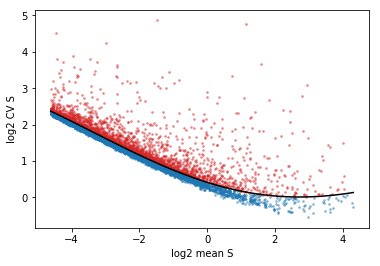

In [165]:
# Rank genes on the basis of a coefficient of variation(CV) vs mean fit, 
# uses support vector regression
ind.score_cv_vs_mean(3000, plot=True, max_expr_avg=20)
ind.filter_genes(by_cv_vs_mean=True)
plt.savefig(print_dir + "{}_feature_selection.pdf".format(ind_name))

In [166]:
print(ind.S.shape)

(3001, 1227)


In [167]:
#normalize data by total molecule count
ind._normalize_S(relative_size=ind.S.sum(0), target_size=ind.S.sum(0).mean())
ind._normalize_U(relative_size=ind.U.sum(0), target_size=ind.U.sum(0).mean())

58


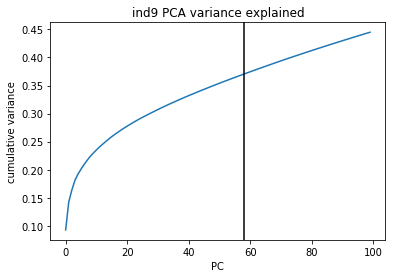

In [169]:
#run pca
ind.perform_PCA()

plt.plot(np.cumsum(ind.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(ind.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.title("{} PCA variance explained".format(ind_name))
plt.xlabel("PC")
plt.ylabel("cumulative variance")
plt.savefig(print_dir + "{}_PCA_variance_explained.pdf".format(ind_name))
print(n_comps)

In [171]:
#run knn imputation
ind.knn_imputation(n_pca_dims=n_comps, k=500, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=16)

In [172]:
ind.fit_gammas()

In [173]:
ind.predict_U()
ind.calculate_velocity()
ind.calculate_shift(assumption="constant_velocity")
ind.extrapolate_cell_at_t(delta_t=1.)

# Visualize RNA velocity

1. **Compute TSNE embeddings**
2. **[Estimate transition probabilities](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=estimate%20transition%20prob#velocyto.analysis.VelocytoLoom.estimate_transition_prob) for each cell to its embedding neighborhood**
3. **Use the transition probability to [project the velocity direction on the embedding](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=calculate_embedding_shift#velocyto.analysis.VelocytoLoom.calculate_embedding_shift)**
    * Also computes a negative control velocity plot, do not fully understand how this works at this point.
4. **[Calculate embedding shift](http://velocyto.org/velocyto.py/fullapi/api_analysis.html?highlight=calculate_embedding_shift#velocyto.analysis.VelocytoLoom.calculate_embedding_shift), use the transition probabilities to project the velocity direction onto the tsne.**
5. **Plot velocity tsne**
    * One velocity arrow for each cell
    * Mean velocity field in a grid


In [261]:
bh_tsne = TSNE()
ind.ts = bh_tsne.fit_transform(ind.pcs[:, :25])


In [262]:
ind.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=3500, knn_random=True, sampled_fraction=0.5)
ind.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

NameError: name 'print_dir' is not defined

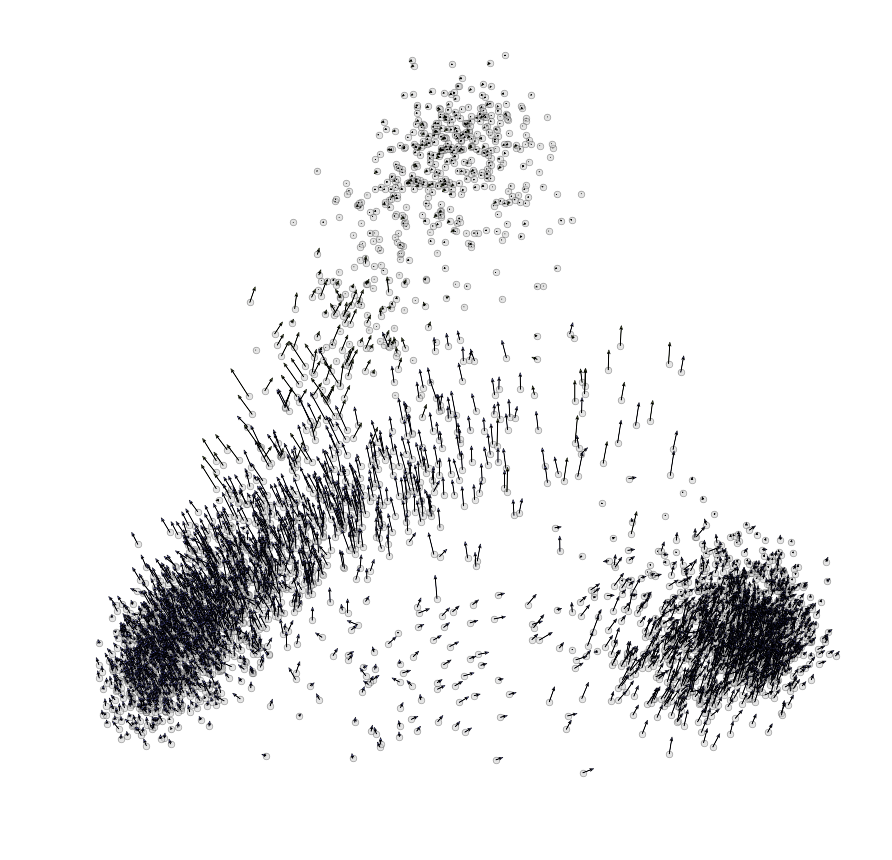

In [3]:
#raw velocity tsne
f, ax = plt.subplots(1,1, figsize=(7,7),dpi=150)
plt.subplot(111)
quiver_scale = 25
plt.scatter(ind.embedding[:, 0], ind.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(ind.embedding.shape[0], size=int(ind.embedding.shape[0]/1.), replace=False)
plt.scatter(ind.embedding[ix_choice, 0], ind.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=ind.colorandum[ix_choice], alpha=1)
plt.quiver(ind.embedding[ix_choice, 0], ind.embedding[ix_choice, 1],
           ind.delta_embedding[ix_choice, 0], ind.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)
plt.axis("off");
plt.savefig(print_dir + "{}_raw_velocity.pdf".format(ind_name))

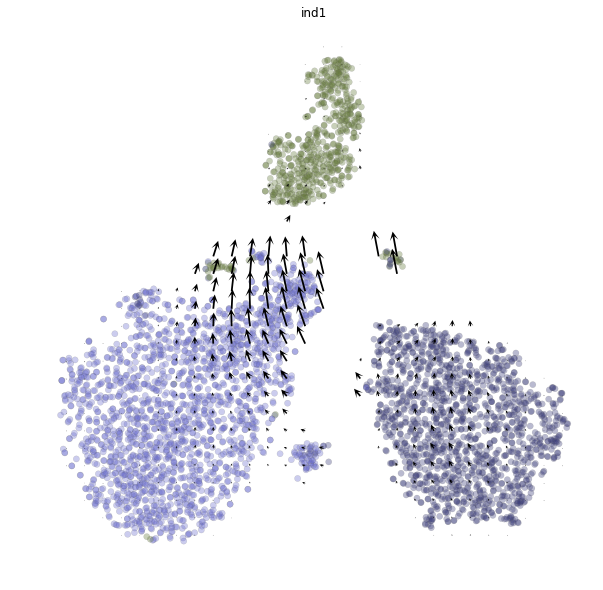

In [271]:
#velocity tsne
ind.calculate_grid_arrows(smooth=0.8, steps=(30, 30), n_neighbors=300)
f, ax = plt.subplots(1,1, figsize=(10,10))
#ax1 = plt.subplot(121)
ind.plot_grid_arrows(quiver_scale=0.075,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=1, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=0.35,
                    plot_random=False, scale_type='absolute')

plt.axis("off");
plt.title(ind_name)
plt.savefig(print_dir + "{}_average_velocity.pdf".format(ind_name))  

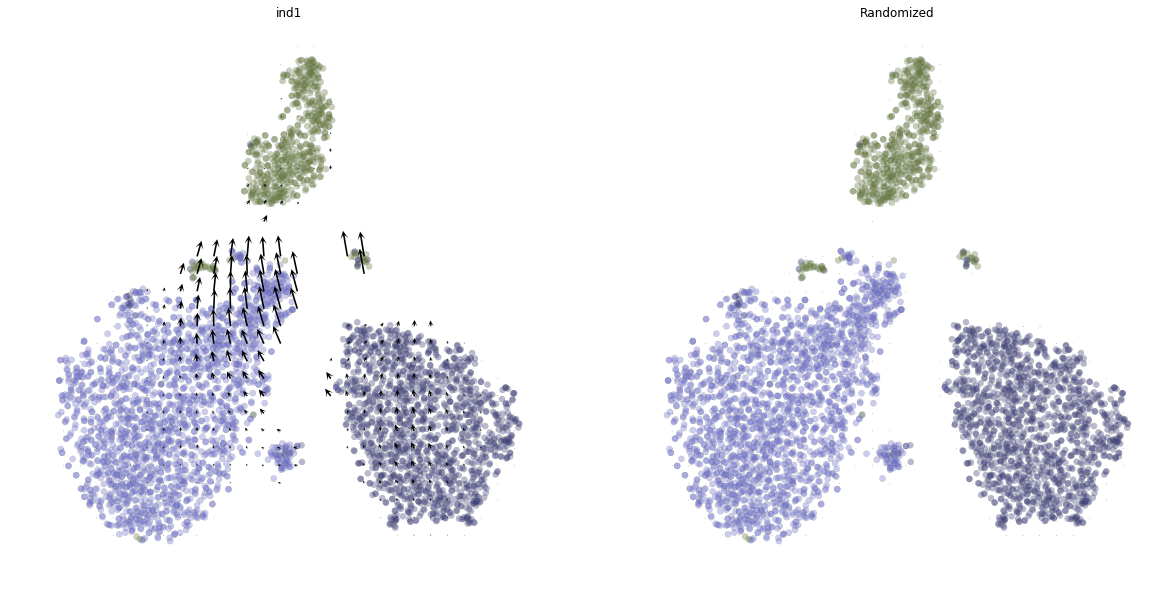

In [272]:
#velocity tsne
ind.calculate_grid_arrows(smooth=0.8, steps=(30, 30), n_neighbors=300)
f, ax = plt.subplots(1,1, figsize=(20,10))
#ax1 = plt.subplot(121)
ind.plot_grid_arrows(quiver_scale=0.075,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=1, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=0.35,
                    plot_random=True, scale_type='absolute')

plt.axis("off");
plt.title(ind_name)
plt.savefig(print_dir + "{}_average_velocity_random.pdf".format(ind_name))  

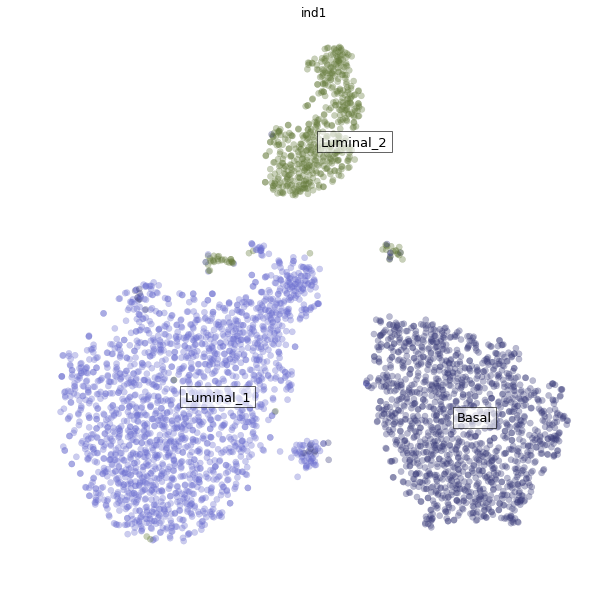

In [269]:
#tsne with cluster names
f, ax = plt.subplots(1,1, figsize=(10,10))
vcy.scatter_viz(ind.ts[:,0], ind.ts[:,1], c=ind.colorandum, s=38, alpha=0.35, lw=0.35, rasterized=True)
#vcy.scatter_viz(ind.ts[:,0], ind.ts[:,1], c=mycolors, s=7.5)

for i in list(set(ind.ca["ClusterName"])):
    ts_m = np.median(ind.ts[ind.ca["ClusterName"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(ind.cluster_labels[ind.ca["ClusterName"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6}) 
plt.axis("off");
plt.title(ind_name)
plt.savefig(print_dir + "{}_tsne_celltypes.pdf".format(ind_name))  

# Part 3: Violin plot of mean velocity magnitudes for each cell type

In [137]:
ind_splice_dict = {cl: defaultdict(list) for cl in list(set(ind.ca["ClusterName"]))}
for cluster in list(set(ind.ca["ClusterName"])):
    for i in range(ind.S.T[ind.ca['ClusterName'] == cluster].T.shape[1]):
        ind_splice_dict[cluster]["spliced"].append(np.sum(ind.S.T[ind.ca['ClusterName'] == cluster].T[:,i]))
        ind_splice_dict[cluster]["unspliced"].append(np.sum(ind.U.T[ind.ca['ClusterName'] == cluster].T[:,i]))

ratios = []
for i, cluster in enumerate(ind_splice_dict.keys()):
    ratios.append(np.divide(ind_splice_dict[cluster]['unspliced'], ind_splice_dict[cluster]['spliced']))


KeyboardInterrupt: 

In [275]:
#unique_data = [list(x) for x in set(tuple(x) for x in testdata)]
mycolors = [list(thing) for thing in set(tuple(x) for x in ind.colorandum)]
mycolors = [mycolors[2], mycolors[1], mycolors[0]]

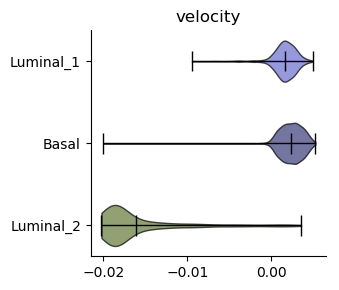

In [276]:
#compute the sum of velocities for all cells:
velocity_sums = np.array([np.mean(ind.velocity[:,i]) for i in range(ind.velocity.shape[1])])

#split this up into each cluster:
data = [velocity_sums[ind.ca["ClusterName"] == cluster] for cluster in list(set(ind.ca["ClusterName"]))]

fig, axes = plt.subplots(1,1, figsize=(6,3),dpi=100)

ax = plt.subplot(121)
violin = plt.violinplot(data, vert=False, showmeans=True);
for i, v in enumerate(violin['bodies']):
    v.set_facecolor(mycolors[i])
    v.set_edgecolor('k')
    v.set_alpha(0.7)

# change the line color from blue to black
for partname in ('cbars','cmins','cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

plt.yticks([], [])
plt.title("velocity")

#edit spines:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
labels = [cluster for cluster in list(set(ind.ca["ClusterName"]))]
plt.yticks([i for i in range(1, len(labels)+1)], labels);
plt.tight_layout()

# ax = plt.subplot(122)
# violin = plt.violinplot(ratios, vert=False, showmeans=True);
# for i, v in enumerate(violin['bodies']):
#     v.set_facecolor(mycolors[i])
#     v.set_edgecolor('k')
#     v.set_alpha(0.7)

# # change the line color from blue to black
# for partname in ('cbars','cmins','cmaxes', 'cmeans'):
#     vp = violin[partname]
#     vp.set_edgecolor('k')
#     vp.set_linewidth(1)

# plt.yticks([], [])
# plt.title("unspliced / spliced")

# #edit spines:
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.tight_layout()
plt.savefig(print_dir + "{}_velocity_magnitudes.pdf".format(ind_name))

# Pseudotime

In [333]:
#Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    d = {'print.me': 'print_dot_me', 'print_me': 'print_uscore_me'}
    princurve = importr("princurve", on_conflict='warn')
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

In [334]:
from sklearn.neighbors import NearestNeighbors
import igraph

nn = NearestNeighbors(50)
nn.fit(ind2.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [335]:
from numpy_groupies import aggregate, aggregate_np

In [336]:
pc_obj = principal_curve(ind2.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/robjects/packages_utils.py:107: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


In [337]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
#ind2.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})
ind2.set_clusters(ind2.ca["ClusterName"])


In [338]:
k = 550
ind2.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, ind2.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, ind2.S.shape[1]-1))

In [339]:
ind2.normalize_median()
ind2.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [340]:
ind2.normalize(which="imputed", size=False, log=True)
ind2.Pcs = np.array(ind2.pcs[:,:2], order="C")

In [341]:
ind2.predict_U()
ind2.calculate_velocity()
ind2.calculate_shift()
ind2.extrapolate_cell_at_t(delta_t=1)

In [342]:
ind2.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [343]:
ind2.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)


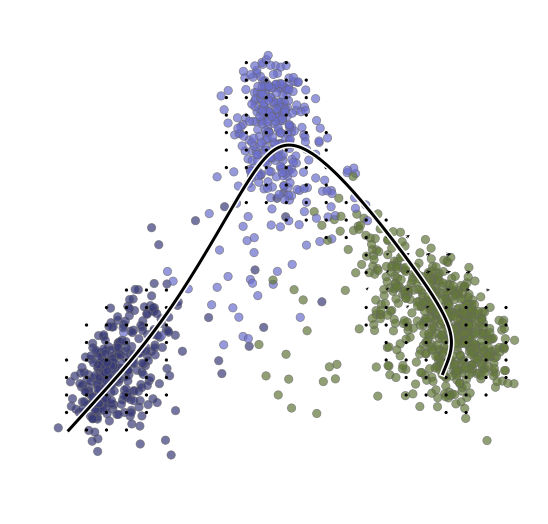

In [344]:
plt.figure(None,(9,9))
ind2.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");
plt.savefig(print_dir + "pseudotime.pdf")

In [345]:
pickle.dump(ind2, open("/data1/rna_velocity_data/ind9/ind9.hdf5", 'wb'))
